**Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import Image
import os

**Checking for GPU Availability**

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


**Data Prep**

In [3]:
# zde bude část, kdy je třeba stáhnout obrázky, otagovat je, a uložit do složky
# FUCK GOOGLE DRIVE
# It takes quite a long time (1m 22s), but it does not need to be ran again
filename = 'dataset.zip'
if not os.path.isdir('train') or not os.path.isdir('val') or not os.path.isfile(filename):
    urlretrieve("https://plik.zapadlo.name/file/LGJjW9v9CbISPMDR/tn89O8CDuRwhUEa4/aquarium_fish_dataset.zip", filename)

    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')
else:
    print('All ready...')

All ready...


**Data Resize** - we want to resize all images to 28x28 format

In [4]:
from torchvision import datasets, transforms

# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

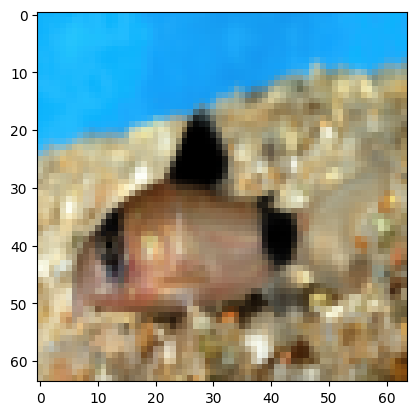

In [5]:
# Needed to run `pip install opencv-python` in the terminal
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("train/Corydoras_panda/Corydoras_panda_1.jpg")
plt.imshow(  transform(img).permute(1, 2, 0)  )

**Dataset Loading**

In [6]:
# Load the dataset - dodělat, až bude hotovo stáhnutí a otagování
train_set = datasets.ImageFolder(root='train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)

# Download and load the test data
test_set = datasets.ImageFolder(root='val/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)

**Builing simple CNN**

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=11)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=11)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=44*44*64, out_features=1028)
        #self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=1028, out_features=256)
        self.fc_end = nn.Linear(in_features=256, out_features=5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        #x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc_end(x)
        return x

model = SimpleCNN().to(device)
model

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(11, 11), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=123904, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=256, bias=True)
  (fc_end): Linear(in_features=256, out_features=5, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
for epoch in range(30): 
    running_loss = 0.0
    for images, labels in train_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/30], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/30], Loss: 1.6109
Epoch [2/30], Loss: 1.6055
Epoch [3/30], Loss: 1.6057
Epoch [4/30], Loss: 1.6004
Epoch [5/30], Loss: 1.5945
Epoch [6/30], Loss: 1.5895
Epoch [7/30], Loss: 1.5880
Epoch [8/30], Loss: 1.5824
Epoch [9/30], Loss: 1.5818
Epoch [10/30], Loss: 1.5759
Epoch [11/30], Loss: 1.5594
Epoch [12/30], Loss: 1.5753
Epoch [13/30], Loss: 1.5671
Epoch [14/30], Loss: 1.5505
Epoch [15/30], Loss: 1.5488
Epoch [16/30], Loss: 1.5538
Epoch [17/30], Loss: 1.5195
Epoch [18/30], Loss: 1.5299
Epoch [19/30], Loss: 1.5184
Epoch [20/30], Loss: 1.5088
Epoch [21/30], Loss: 1.4908
Epoch [22/30], Loss: 1.4972
Epoch [23/30], Loss: 1.4676
Epoch [24/30], Loss: 1.4862
Epoch [25/30], Loss: 1.4650
Epoch [26/30], Loss: 1.4358
Epoch [27/30], Loss: 1.4679
Epoch [28/30], Loss: 1.4101
Epoch [29/30], Loss: 1.4105
Epoch [30/30], Loss: 1.4227


In [10]:
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, labels in test_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 44.50%
